<a href="https://colab.research.google.com/github/NayelySaldivar/DesafioData/blob/main/Unsupervised_ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> Desafío Data México </h2>
<h4> <p> Segunda Edición - Datos con perspectiva de género </p> </h4> 

##### Importación de librerías:

In [1]:
import pandas as pd
import numpy as np
import requests
import plotly.express as px
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Carga de Bases de Datos:

### - Resultados Covid desde la plataforma **DataMexico**:

- Utilizamos la **DataMexico API Explorer** para obtener los datos actualizados:

In [3]:
data=requests.get('https://api.datamexico.org/tesseract/cubes/gobmx_covid/aggregate.jsonrecords?drilldowns%5B%5D=Death+Date.Death+Date.Death+Date&drilldowns%5B%5D=Covid+Result.Covid+Result.Covid+Result&drilldowns%5B%5D=Health+Institution+Attended.Health+Institution+Attended.Health+Institution+Attended&drilldowns%5B%5D=Pneumonia+Diagnose.Pneumonia+Diagnose.Pneumonia+Diagnose&drilldowns%5B%5D=COPD+Diagnose.COPD+Diagnose.COPD+Diagnose&drilldowns%5B%5D=Asthma+Diagnose.Asthma+Diagnose.Asthma+Diagnose&drilldowns%5B%5D=Inmunosupresion+Diagnose.Inmunosupresion+Diagnose.Inmunosupresion+Diagnose&drilldowns%5B%5D=Hypertension+Diagnose.Hypertension+Diagnose.Hypertension+Diagnose&drilldowns%5B%5D=Cardiovascular+Diagnose.Cardiovascular+Diagnose.Cardiovascular+Diagnose&drilldowns%5B%5D=Obesity+Diagnose.Obesity+Diagnose.Obesity+Diagnose&drilldowns%5B%5D=Chronic+Kidney+Failure+Diagnose.Chronic+Kidney+Failure+Diagnose.Chronic+Kidney+Failure+Diagnose&drilldowns%5B%5D=Diabetes+Diagnose.Diabetes+Diagnose.Diabetes+Diagnose&drilldowns%5B%5D=State+Patient+Attended.State+Patient+Attended.State+Patient+Attended&drilldowns%5B%5D=State+Patient+Origin.State+Patient+Origin.State+Patient+Origin&drilldowns%5B%5D=Sex.Sex.Sex&drilldowns%5B%5D=Age+Group.Age+Group.Age&drilldowns%5B%5D=Municipality+Patient+Residence.Geography.Municipality&measures%5B%5D=Cases&parents=false&sparse=false')
data_api=pd.DataFrame(data.json()["data"])
data_api.shape

### - Datos históricos de **Mortalidad en Mujeres 2012-2019** del INEGI:

In [6]:
mortalidad_mujeres=pd.read_csv(f'/content/drive/MyDrive/DesafioData/Base_INEGI_Mujeres.csv')
mortalidad_mujeres.shape

### - Catálogo de enfermedades según la **CIE - 10**

Concatenamos todas las incidencias:

In [12]:
CIE=pd.read_csv(f'/content/drive/MyDrive/DesafioData/Catalogo_CIE_10.csv', encoding='latin-1')

## Preparación de la información para construir el modelo

In [ ]:
!pip install feature_engine

### Tabulados de Mortalidad **INEGI**

Debido a la cantidad de datos y los recursos con los que contamos, decidimos tomar el último quiquenio que tenemos registrado en el histórico de muertes para crear nuestro modelo de ML:

In [27]:
data_mujeres_quinquenio = mortalidad_mujeres[mortalidad_mujeres['date'].isin([2015,2016,2017,2018,2019])].reset_index(drop=True)

Volvemos dummies las variables de los grupos de enfermedad:

In [28]:
data_mujeres=data_mujeres_quinquenio['gpo_enfermedad']

In [29]:
dum_df = pd.get_dummies(data_mujeres, columns=['gpo_enfermedad'], prefix="Gpo_Enfermedad_is")

Añadimos las variables que coinciden con la base de COVID:

In [30]:
data_mujeres=pd.concat([dum_df,data_mujeres_quinquenio[['sexo','edad_real','derechohab','ent_regis']]],axis=1)
data_mujeres.head(2)

,Gpo_Enfermedad_is_EPOC,Gpo_Enfermedad_is_asma,Gpo_Enfermedad_is_cardiovascular,Gpo_Enfermedad_is_diabetes,Gpo_Enfermedad_is_hipertension,Gpo_Enfermedad_is_inmunosupresores,Gpo_Enfermedad_is_insuf_renal,Gpo_Enfermedad_is_neumonia,Gpo_Enfermedad_is_obesidad,Gpo_Enfermedad_is_otros,sexo,edad_real,derechohab,ent_regis
0,0,0,0,0,0,0,0,0,0,1,2,40,7,1
1,0,0,0,0,0,0,0,0,0,1,2,66,2,1


Eliminamos los registros que queden fuera de nuestros grupos de enfermedad:

In [31]:
rows_to_drop=data_mujeres[data_mujeres['Gpo_Enfermedad_is_otros']==1].index
data_mujeres_limpia=data_mujeres.copy()

print(f'Shape Inicial: {data_mujeres_limpia.shape}')
data_mujeres_limpia=data_mujeres_limpia.drop(rows_to_drop,axis=0).reset_index(drop=True)
data_mujeres_limpia=data_mujeres_limpia.drop('Gpo_Enfermedad_is_otros',axis=1)
print(f'Shape Inicial: {data_mujeres_limpia.shape}')

Shape Inicial: (1488372, 14)
Shape Inicial: (988232, 13)


### Datos **Covid-19** API Data México

Homologamos los valores dummies de la base:

In [34]:
enfermedades=['Pneumonia Diagnose ID','COPD Diagnose ID','Asthma Diagnose ID','Inmunosupresion Diagnose ID','Hypertension Diagnose ID','Cardiovascular Diagnose ID','Obesity Diagnose ID','Chronic Kidney Failure Diagnose ID','Diabetes Diagnose ID']

for enf in enfermedades:
  data_api[enf]=np.where(data_api[enf]==1,1,0)

Orden de las columnas

In [35]:
# columnas_ml=['EPOC','Asma','Cardiovascular','Diabetes','Hipertension','Inmunosupresion','Inf_Renal','Neumonia','Obesidad','Sexo','Edad','Institucion','Estado','Municipio']
data_api_ml_completo=data_api[['COPD Diagnose ID','Asthma Diagnose ID','Cardiovascular Diagnose ID','Diabetes Diagnose ID','Hypertension Diagnose ID','Inmunosupresion Diagnose ID','Chronic Kidney Failure Diagnose ID','Pneumonia Diagnose ID','Obesity Diagnose ID','Sex ID','Age','Health Institution Attended','State Patient Attended ID']]

Encoding del tipo de institución en el que se atendió el fallecido

In [ ]:
data_api_ml_completo['Health Institution Attended']=np.where(
    data_api_ml_completo['Health Institution Attended']=='IMSS',2,np.where(
    data_api_ml_completo['Health Institution Attended']=='ISSSTE',3,np.where(
    data_api_ml_completo['Health Institution Attended']=='PEMEX',4,np.where(
    data_api_ml_completo['Health Institution Attended']=='SEDENA',5,np.where(
    data_api_ml_completo['Health Institution Attended']=='SEMAR',6,np.where(
    data_api_ml_completo['Health Institution Attended']=='IMSS-Bienestar',7,8    
    )    
    )
    )    
    )    
    )
    )

## Unificación de variables

Tenemos nuestras bases completas, ahora hay que homologar el nombre de las columnas:

In [ ]:
data_inegi_ml=data_mujeres_limpia.copy().drop('sexo',axis=1)
data_api_ml=data_api_ml_completo[data_api_ml_completo['Sex ID']==2].drop('Sex ID',axis=1).reset_index(drop=True)

columnas_ml=['EPOC','Asma','Cardiovascular','Diabetes','Hipertension','Inmunosupresion','Inf_Renal','Neumonia','Obesidad','Edad','Institucion','Estado']
data_inegi_ml.columns=columnas_ml
data_api_ml.columns=columnas_ml

In [ ]:
# data_api_ml_completo.to_csv('Base_Covid_2303.csv')

## Unsupervised ML - Clusterización 

### K Means

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Con ayuda el elbow method buscamos el número de clusters óptimo para la partición:

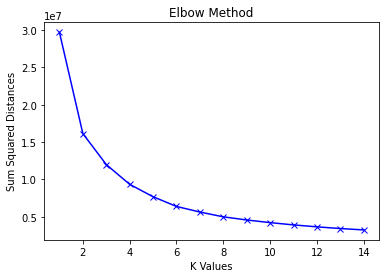

In [ ]:
K = range(1,15)
sum_squared_distances = []
for k in K:
  model = KMeans(n_clusters=k).fit(data_api_ml)
  sum_squared_distances.append(model.inertia_)
plt.plot(K, sum_squared_distances, "bx-")
plt.xlabel("K Values")
plt.ylabel("Sum Squared Distances")
plt.title("Elbow Method")
plt.show()

Identificamos 6 clusters

In [ ]:
kmeans = KMeans(n_clusters=6)
data_api_clusters = kmeans.fit(data_api_ml)
preds = data_api_clusters.fit_predict(data_api_ml)

Marcamos cada cluster en la base con la columna **cluster**:

In [ ]:
data_api_ml['Cluster_KMeans']=preds
data_api_ml.head(2)

,EPOC,Asma,Cardiovascular,Diabetes,Hipertension,Inmunosupresion,Inf_Renal,Neumonia,Obesidad,Edad,Institucion,Estado,Cluster_KMeans
0,0,0,0,0,0,1,0,0,0,65,2,9,2
1,0,0,0,1,0,0,0,0,1,67,2,5,2


In [ ]:
# data_api_ml[data_api_ml.Cluster==0].Estado.value_counts()

### DBSCAN

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

Con ayuda de NN identificamos la distancia óptima

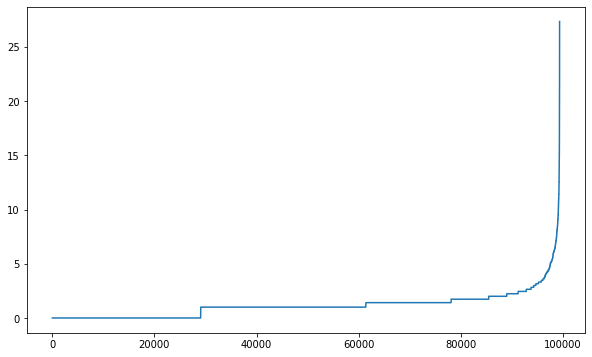

In [ ]:
nearest_neighbors = NearestNeighbors(n_neighbors=100)
nearest_neighbors.fit(data_api_ml.drop('Cluster',axis=1))
distances, indices = nearest_neighbors.kneighbors(data_api_ml.drop('Cluster',axis=1))
distances = np.sort(distances, axis=0)[:,1]
plt.figure(figsize=(10,6))
plt.plot(distances)
plt.show()

Creamos el modelo:

In [ ]:
m = DBSCAN(eps=3, min_samples=28)
m.fit(data_api_ml.drop('Cluster',axis=1))

DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=28, n_jobs=None, p=None)

Creamos los cluster y etiquetamos el ruido.

In [ ]:
#Asignar nuestros labels/clusters
labels = m.labels_

#Empezar a enmascarar nuestros datos
labels_mask_general = np.zeros_like(labels,dtype=bool)

#Colocar outliers como verdadero
labels_mask_general[m.core_sample_indices_] = True

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f'Número de clusters: {n_clusters}')
print(f'Registros con ruido: {n_noise}')

Número de clusters: 121
Registros con ruido: 35776


In [ ]:
data_api_ml['Cluster_DBSCAN']=labels
data_api_ml.head(2)

,EPOC,Asma,Cardiovascular,Diabetes,Hipertension,Inmunosupresion,Inf_Renal,Neumonia,Obesidad,Edad,Institucion,Estado,Municipio,Cluster,Cluster_DBSCAN
0,0,0,0,0,0,1,0,0,0,65,2,9,9007,0,0
1,0,0,0,1,0,0,0,0,1,67,2,5,5030,0,1


Analicemos los clusters:

### HDBSCAN

In [ ]:
pip install hdbscan

In [ ]:
import sklearn.cluster as cluster
import scipy.cluster.hierarchy as sch
import hdbscan
from random import sample 

Para la visualización del dendograma y visualizar los parámetros de clusterización tomaremos una muestra aleatoria de los datos:

In [ ]:
muestra_hdbscan=data_api_ml.drop(['Cluster','Cluster_DBSCAN'],axis=1).sample(frac=.1)

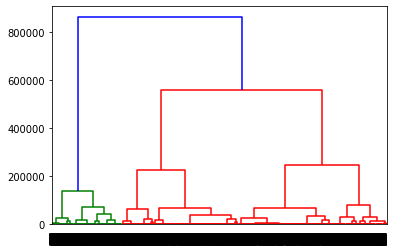

In [ ]:
dendogram = sch.dendrogram(sch.linkage(muestra_hdbscan,method='ward'))
plt.title('Dendogram')
plt.xlabel('Customers')
plt.ylabel('Distancia Euclidiana')
plt.show()

Tomando la distancia vertical más larga y contando las veces que cruza con otras ramos, obtenemos que el tamaño minimo de los clusters debe ser de . 
Ejecutamos el modelo con esos parámetros:

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
m.fit(data_api_ml.drop(['Cluster','Cluster_DBSCAN'],axis=1))

DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=28, n_jobs=None, p=None)

In [ ]:
# Asignar nuestros labels/clusters
labels = m.labels_

# Empezar a enmascarar nuestros datos
labels_mask_general = np.zeros_like(labels,dtype=bool)

# Colocar outliers como verdadero
labels_mask_general[m.core_sample_indices_] = True

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f'Número de clusters: {n_clusters}')
print(f'Registros con ruido: {n_noise}')

Número de clusters: 121
Registros con ruido: 35776


Asignamos los labels obtenidos:

In [ ]:
data_api_ml['Cluster_HDBSCAN']=labels
data_api_ml.head(2)

,EPOC,Asma,Cardiovascular,Diabetes,Hipertension,Inmunosupresion,Inf_Renal,Neumonia,Obesidad,Edad,Institucion,Estado,Municipio,Cluster,Cluster_DBSCAN,Cluster_HDBSCAN
0,0,0,0,0,0,1,0,0,0,65,2,9,9007,0,0,0
1,0,0,0,1,0,0,0,0,1,67,2,5,5030,0,1,1


### GMM

In [ ]:
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.pyplot import figure

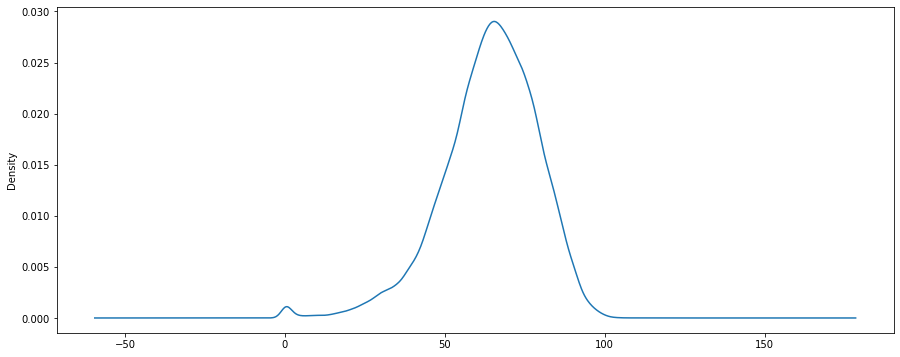

In [ ]:
figure(figsize=(15,6))
data_api_ml.Edad.plot(kind='kde');

Para obtener el número de componentes, obtenemos el valor de las 4 covarianzas.

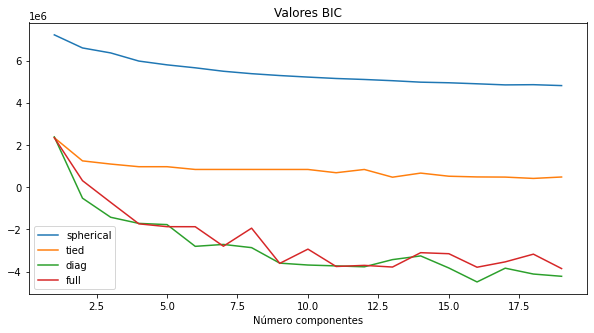

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

n_components = range(1, 20)
covariance_types = ['spherical', 'tied', 'diag', 'full']

for covariance_type in covariance_types:
    valores_bic = []
    
    for i in n_components:
        modelo = GMM(n_components=i, covariance_type=covariance_type)
        modelo = modelo.fit(data_api_ml.drop('Cluster_KMeans',axis=1))
        valores_bic.append(modelo.bic(data_api_ml.drop('Cluster_KMeans',axis=1)))
        # modelo = modelo.fit(data_api_ml.drop(['Cluster','Cluster_DBSCAN','Cluster_HDBSCAN'],axis=1))
        # valores_bic.append(modelo.bic(data_api_ml.drop(['Cluster','Cluster_DBSCAN','Cluster_HDBSCAN'],axis=1)))
        
    ax.plot(n_components, valores_bic, label=covariance_type)
ax.set_title("Valores BIC")
ax.set_xlabel("Número componentes")
ax.legend();

Corremos el modelo con el número de componentes = 13. 

In [ ]:
gm  = GMM(n_components=13, covariance_type='full')
gm.fit(data_api_ml.drop('Cluster_KMeans',axis=1))
# gm.fit(data_api_ml.drop(['Cluster','Cluster_DBSCAN','Cluster_HDBSCAN'],axis=1))

labels = gm.predict(data_api_ml.drop('Cluster_KMeans',axis=1))
# labels = gm.predict(data_api_ml.drop(['Cluster','Cluster_DBSCAN','Cluster_HDBSCAN'],axis=1))
data_api_ml['Cluster_GMM']= labels
data_api_ml.head(2)

,EPOC,Asma,Cardiovascular,Diabetes,Hipertension,Inmunosupresion,Inf_Renal,Neumonia,Obesidad,Edad,Institucion,Estado,Cluster_KMeans,Cluster_GMM
0,0,0,0,0,0,1,0,0,0,65,2,9,2,7
1,0,0,0,1,0,0,0,0,1,67,2,5,2,3


In [ ]:
# data_api_ml['Cluster_GMM'].value_counts()

### Evaluando nuestro modelo

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
silhouette_score(data_api_ml.drop(['Cluster_KMeans'],axis=1),kmeans.labels_,metric='euclidean',sample_size=len(X))

In [ ]:
data_api_ml.to_csv('Cluster_Covid.csv')